#XGBoost


Realizamos los importes necesarios para trabajar.

In [17]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
colors = sns.color_palette(n_colors=15)

Bajamos los dataframes que usaremos.

In [18]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

In [19]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

In [20]:
# Contamos los valores faltantes
num_missing = df_hotel.isna().sum()
print("El número total de valores faltantes en el DataFrame es:", num_missing.sum())

El número total de valores faltantes en el DataFrame es: 0


In [21]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [22]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

In [23]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

In [24]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

In [25]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

## XGBoost sin optimización

In [26]:
#Creamos conjuntos de train y test 80-20
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

#Hacemos la predicción y calculamos las métricas
y_pred=xgb_model.predict(x_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)


F1_score en el conjunto de prueba: 0.8716254331533564
Accuracy en el conjunto de prueba: 0.8704667425597659
Precision en el conjunto de prueba: 0.8596407566364648


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6180
           1       0.86      0.88      0.87      6118

    accuracy                           0.87     12298
   macro avg       0.87      0.87      0.87     12298
weighted avg       0.87      0.87      0.87     12298



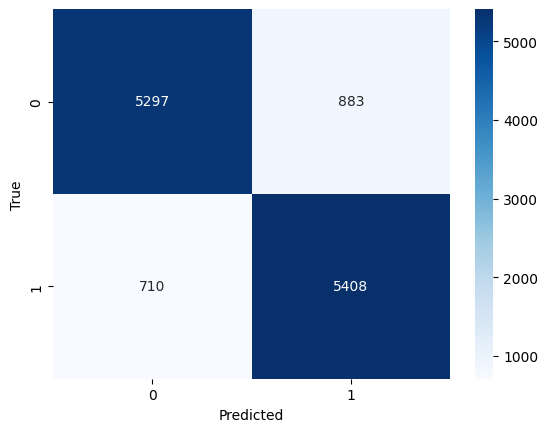

In [27]:
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

Observamos que el rendimiento de XGBoost es destacable a pesar de no haber optimizado sus hiperparámetros.

## XGBoost con CrossValidation

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

param_dist = {
    'learning_rate': [0.01, 0.02],
    'max_depth': list(range(10,20)),
    'n_estimators': [450, 500, 550],
    'gamma': [0, 0.001, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7, 0.9, 1],
    'reg_alpha': [0, 0.1, 0.2, 0.05],
    'reg_lambda': [0, 0.1, 0.8, 1, 1.5]
}

# Nota: si no se indica el objective TypeError tira "Cannot clone object"
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=1,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_model = xgb.XGBClassifier(**best_params)

best_model.fit(x_train, y_train)

y_pred=best_model.predict(x_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros encontrados: {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 550, 'max_depth': 17, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
F1_score en el conjunto de prueba: 0.8826328950552554
Accuracy en el conjunto de prueba: 0.8816880793624979
Precision en el conjunto de prueba: 0.8713170887083931


              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6180
           1       0.87      0.89      0.88      6118

    accuracy                           0.88     12298
   macro avg       0.88      0.88      0.88     12298
weighted avg       0.88      0.88      0.88     12298



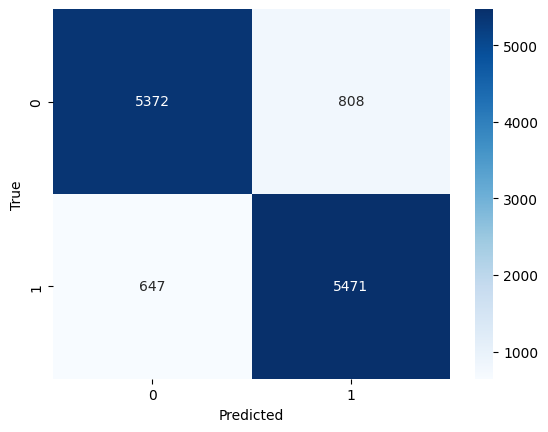

In [29]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

Como se puede observar, el ensamble tiene un mejor puntaje F1 luego de optimizar sus hiperparámetros. Consideramos que es posible optimizarlo aun más, pero esto aumenta el tiempo que toma en correr el código de arriba. A pesar de esto creemos que un puntaje F1 de 0.88 es más que satisfactorio si lo comparamos al desempeño de los anteriores ensambles.

In [32]:
import joblib
joblib.dump(best_model, 'modelo_xgb_final.pkl')
loaded_model = joblib.load('modelo_xgb_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

In [33]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_XGB_1.csv', index=False)